In [2]:
import pandas as pd
df = pd.read_csv('blueprinty.csv')
df.head()

,patents,region,age,iscustomer
0,0,Midwest,32.5,0
1,3,Southwest,37.5,0
2,4,Northwest,27.0,1
3,3,Northeast,24.5,0
4,3,Southwest,37.0,0


<Axes: xlabel='age', ylabel='Density'>

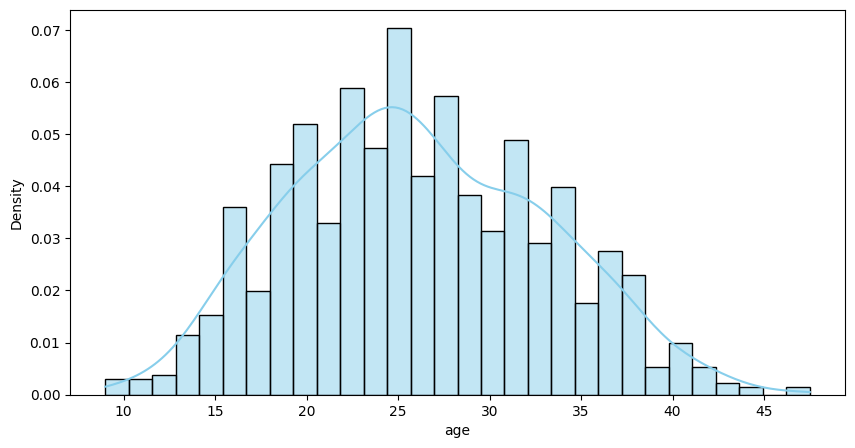

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reload the dataset
df = pd.read_csv("blueprinty.csv")

# Set up the combined histogram + KDE plot
plt.figure(figsize=(10, 5))

# Histogram and KDE for non-customers
sns.histplot(df[df['iscustomer'] == 0]['age'],
             bins=30,
             kde=True,
             stat="density",
             label='Not Using Blueprinty',
             color='skyblue',
             alpha=0.5)

In [4]:
age_distribution_non_customers = df[df['iscustomer'] == 0]['age'].value_counts().sort_index()
age_distribution_non_customers

age
9.0     1
9.5     1
10.0    2
11.0    1
11.5    3
       ..
43.0    1
43.5    1
44.0    2
46.5    1
47.5    1
Name: count, Length: 72, dtype: int64

In [5]:
import numpy as np
from scipy.special import gammaln

def poisson_loglikelihood(lmbda, y):
    """
    Compute the log-likelihood of a Poisson model.
    
    Parameters:
        lmbda: array-like, predicted Poisson means (e.g. exp(X @ beta))
        y: array-like, observed counts

    Returns:
        log-likelihood value (scalar)
    """
    lmbda = np.asarray(lmbda)
    y = np.asarray(y)
    return np.sum(-lmbda + y * np.log(lmbda) - gammaln(y + 1))

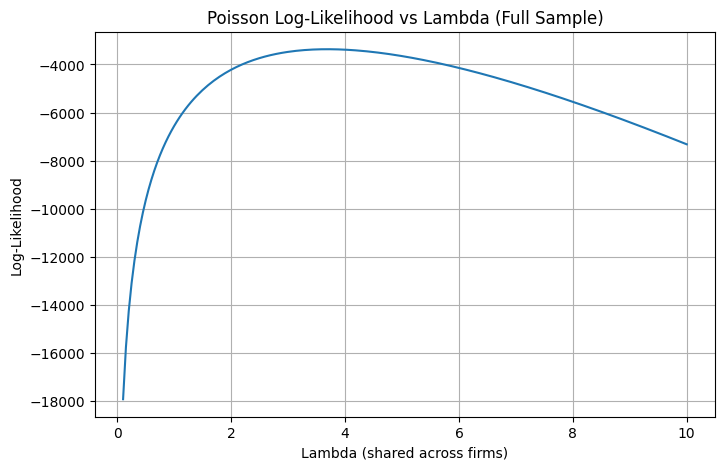

In [6]:
y_obs_full = df['patents'].values

lambda_range = np.linspace(0.1, 10, 200)

log_likelihoods_full = [poisson_loglikelihood(lmbda=np.repeat(lmb, len(y_obs_full)), y=y_obs_full)
                        for lmb in lambda_range]

plt.figure(figsize=(8, 5))
plt.plot(lambda_range, log_likelihoods_full)
plt.title('Poisson Log-Likelihood vs Lambda (Full Sample)')
plt.xlabel('Lambda (shared across firms)')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()

In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

# 定义负的 log-likelihood（因为 minimize 默认最小化）
def neg_log_likelihood(lmbda_scalar, y):
    lmbda = np.repeat(lmbda_scalar[0], len(y))
    return -np.sum(-lmbda + y * np.log(lmbda) - gammaln(y + 1))

# 目标数据
y_data = df['patents'].values

# 初始猜测（可以用平均值）
initial_guess = [np.mean(y_data)]

# 使用 scipy.optimize.minimize 进行拟合
result = minimize(neg_log_likelihood, x0=initial_guess, args=(y_data,), bounds=[(0.0001, None)])

# 打印结果
lambda_mle = result.x[0]
print(f"MLE for lambda (via optimization): {lambda_mle:.4f}")

MLE for lambda (via optimization): 3.6847


In [8]:
import numpy as np
from scipy.special import gammaln

def neg_poisson_loglikelihood(beta, X, y):
    beta = np.asarray(beta)
    X = np.asarray(X)
    y = np.asarray(y)


    linear_pred = X @ beta
    lmbda = np.exp(linear_pred)
    log_lik = -lmbda + y * np.log(lmbda) - gammaln(y + 1)
    return -np.sum(log_lik)

In [9]:
from scipy.optimize import minimize

X = df[['age']].copy()
X['age_squared'] = X['age']**2
X['iscustomer'] = df['iscustomer']

X = pd.concat([X, pd.get_dummies(df['region'], drop_first=True)], axis=1)
X = X.astype(float)
X = X.values

y = df['patents'].values

init_beta = np.ones(X.shape[1]) * 0.1

res = minimize(
    fun=neg_poisson_loglikelihood,
    x0=init_beta,
    args=(X, y),
    method='Nelder-Mead',
    options={'disp': True, 'maxiter': 1000}
)

beta_mle = res.x
print("Estimated beta coefficients:")
print(beta_mle)

Optimization terminated successfully.
         Current function value: 3266.879001
         Iterations: 577
         Function evaluations: 905
Estimated beta coefficients:
[ 0.10525892 -0.00218266  0.14027886  0.13123288  0.05349781  0.1434903
  0.12860536]


In [10]:
print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3266.879001345187
             x: [ 1.053e-01 -2.183e-03  1.403e-01  1.312e-01  5.350e-02
                  1.435e-01  1.286e-01]
           nit: 577
          nfev: 905
 final_simplex: (array([[ 1.053e-01, -2.183e-03, ...,  1.435e-01,
                         1.286e-01],
                       [ 1.052e-01, -2.182e-03, ...,  1.435e-01,
                         1.286e-01],
                       ...,
                       [ 1.052e-01, -2.182e-03, ...,  1.435e-01,
                         1.286e-01],
                       [ 1.053e-01, -2.183e-03, ...,  1.435e-01,
                         1.285e-01]]), array([ 3.267e+03,  3.267e+03,  3.267e+03,  3.267e+03,
                        3.267e+03,  3.267e+03,  3.267e+03,  3.267e+03]))


In [11]:
X = df[['age']].copy()
X['age_squared'] = X['age'] ** 2
X['iscustomer'] = df['iscustomer']

X.insert(0, 'intercept', 1)

X = pd.concat([X, pd.get_dummies(df['region'], drop_first=True)], axis=1)
X = X.astype(float).values

In [12]:
from scipy.optimize import minimize
import numpy as np

init_beta = np.zeros(X.shape[1])

res = minimize(
    fun=neg_poisson_loglikelihood,
    x0=init_beta,
    args=(X, y),
    method='Nelder-Mead',
    options={'disp': True, 'maxiter': 2000}
)

beta_mle = res.x
print("Estimated beta coefficients:")
print(beta_mle)

Optimization terminated successfully.
         Current function value: 3259.214530
         Iterations: 685
         Function evaluations: 1054
Estimated beta coefficients:
[-0.32950681  0.13700644 -0.00276358  0.21449006 -0.01353866 -0.05320079
  0.02214911  0.04299568]


In [13]:
import pandas as pd
import numdifftools as nd

hessian_fun = nd.Hessian(lambda b: neg_poisson_loglikelihood(b, X, y))
H = hessian_fun(beta_mle)

cov_matrix = np.linalg.inv(H)
standard_errors = np.sqrt(np.diag(cov_matrix))

columns = ['intercept', 'age', 'age_squared', 'iscustomer'] + list(pd.get_dummies(df['region'], drop_first=True).columns)

results_table = pd.DataFrame({
    'Variable': columns,
    'Beta': beta_mle,
    'Std. Error': standard_errors
})

results_table

/var/folders/32/xz9pd3zx1yv2tk_19psx52z40000gn/T/ipykernel_23113/3045299706.py:11: RuntimeWarning: overflow encountered in exp
  lmbda = np.exp(linear_pred)


,Variable,Beta,Std. Error
0,intercept,-0.329507,6.520750e-02
1,age,0.137006,2.057879e-03
2,age_squared,-0.002764,1.473287e-09
3,iscustomer,0.214490,3.075139e-02
4,Northeast,-0.013539,4.321331e-02
5,Northwest,-0.053201,5.356145e-02
6,South,0.022149,5.239738e-02
7,Southwest,0.042996,4.660574e-02


In [14]:
import statsmodels.api as sm
import pandas as pd

X_check = df[['age']].copy()
X_check['age_squared'] = X_check['age']**2
X_check['iscustomer'] = df['iscustomer']
X_check = pd.concat([X_check, pd.get_dummies(df['region'], drop_first=True)], axis=1)
X_check = sm.add_constant(X_check) 
X_check = X_check.astype(float)

glm_poisson = sm.GLM(df['patents'], X_check, family=sm.families.Poisson())
glm_results = glm_poisson.fit()

print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                patents   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1492
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3258.1
Date:                Wed, 07 May 2025   Deviance:                       2143.3
Time:                        19:37:52   Pearson chi2:                 2.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1360
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5089      0.183     -2.778      

In [18]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Assuming X and y are your data
X_df = pd.DataFrame(X, columns=[
    'intercept', 'age', 'age_squared', 'iscustomer',
    'Northeast', 'Northwest', 'South', 'Southwest'
])

# Fit the model if it's not already done
model = sm.GLM(y, X_df, family=sm.families.Poisson(link=sm.families.links.log())).fit()

# Now create counterfactuals
X_0 = X_df.copy()
X_0['iscustomer'] = 0

X_1 = X_df.copy()
X_1['iscustomer'] = 1

# Predict
y_pred_0 = model.predict(X_0)
y_pred_1 = model.predict(X_1)

# Treatment effect
treatment_effect = y_pred_1 - y_pred_0
average_effect = treatment_effect.mean()

average_effect

/Users/wenxinxu/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


np.float64(0.7927680710452972)

In [28]:
df = pd.read_csv("airbnb.csv")
df.head()

,Unnamed: 0,id,days,last_scraped,host_since,room_type,bathrooms,bedrooms,price,number_of_reviews,review_scores_cleanliness,review_scores_location,review_scores_value,instant_bookable
0,1,2515,3130,4/2/2017,9/6/2008,Private room,1.0,1.0,59,150,9.0,9.0,9.0,f
1,2,2595,3127,4/2/2017,9/9/2008,Entire home/apt,1.0,0.0,230,20,9.0,10.0,9.0,f
2,3,3647,3050,4/2/2017,11/25/2008,Private room,1.0,1.0,150,0,NaN,NaN,NaN,f
3,4,3831,3038,4/2/2017,12/7/2008,Entire home/apt,1.0,1.0,89,116,9.0,9.0,9.0,f
4,5,4611,3012,4/2/2017,1/2/2009,Private room,NaN,1.0,39,93,9.0,8.0,9.0,t


In [29]:
df

,Unnamed: 0,id,days,last_scraped,host_since,room_type,bathrooms,bedrooms,price,number_of_reviews,review_scores_cleanliness,review_scores_location,review_scores_value,instant_bookable
0,1,2515,3130,4/2/2017,9/6/2008,Private room,1.0,1.0,59,150,9.0,9.0,9.0,f
1,2,2595,3127,4/2/2017,9/9/2008,Entire home/apt,1.0,0.0,230,20,9.0,10.0,9.0,f
2,3,3647,3050,4/2/2017,11/25/2008,Private room,1.0,1.0,150,0,NaN,NaN,NaN,f
3,4,3831,3038,4/2/2017,12/7/2008,Entire home/apt,1.0,1.0,89,116,9.0,9.0,9.0,f
4,5,4611,3012,4/2/2017,1/2/2009,Private room,NaN,1.0,39,93,9.0,8.0,9.0,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40623,40624,18008937,266,4/2/2017,7/10/2016,Entire home/apt,1.5,2.0,150,0,NaN,NaN,NaN,t
40624,40625,18009045,366,4/2/2017,4/1/2016,Private room,1.0,1.0,125,0,NaN,NaN,NaN,f
40625,40626,18009065,587,4/2/2017,8/24/2015,Private room,1.0,1.0,80,0,NaN,NaN,NaN,t
40626,40627,18009650,335,4/2/2017,5/2/2016,Private room,1.0,1.0,69,0,NaN,NaN,NaN,t


In [30]:
df.describe()
df.isna().mean().sort_values(ascending=False)

review_scores_value          0.252437
review_scores_location       0.252388
review_scores_cleanliness    0.250935
bathrooms                    0.003938
bedrooms                     0.001871
host_since                   0.000861
Unnamed: 0                   0.000000
id                           0.000000
days                         0.000000
last_scraped                 0.000000
room_type                    0.000000
price                        0.000000
number_of_reviews            0.000000
instant_bookable             0.000000
dtype: float64

In [31]:
df_clean = df.dropna(subset=[
    'review_scores_value', 
    'review_scores_location', 
    'review_scores_cleanliness'
])

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Poisson regression model
model = smf.glm(
    formula="number_of_reviews ~ price + C(room_type) + review_scores_cleanliness + review_scores_location + review_scores_value + C(instant_bookable)",
    data=df_clean,
    family=sm.families.Poisson()
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      number_of_reviews   No. Observations:                30346
Model:                            GLM   Df Residuals:                    30338
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.3507e+05
Date:                Wed, 07 May 2025   Deviance:                   9.4783e+05
Time:                        20:03:25   Pearson chi2:                 1.42e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5380
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        3.5679      0.015    233.369      0.000       3.538       3.598
C(room_type)[T.Private room]    -0.0252      0.003     -9.406      0.000      -0.031      -0.020
C(room_type)[T.Shared room]     -0.2648      0.009    -30.926      0.000      -0.282      -0.248
C(instant_bookable)[T.t]         0.3324      0.003    115.542      0.000       0.327       0.338
price                        -7.422e-06   7.57e-06     -0.980      0.327   -2.23e-05    7.42e-06
review_scores_cleanliness        0.1130      0.001     76.151      0.000       0.110       0.116
review_scores_location          -0.0821      0.002    -51.797      0.000      -0.085      -0.079
review_scores_value             -0.0900      0.002    -50.354      0.000      -0.094      -0.087
================================================================================================
"""

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit the model (formula same as in Poisson)
nb_model = smf.glm(
    formula="number_of_reviews ~ price + C(room_type) + C(instant_bookable) + review_scores_cleanliness + review_scores_location + review_scores_value",
    data=df_clean,
    family=sm.families.NegativeBinomial()
).fit()

nb_model.summary()

/Users/wenxinxu/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      number_of_reviews   No. Observations:                30346
Model:                            GLM   Df Residuals:                    30338
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2313e+05
Date:                Wed, 07 May 2025   Deviance:                       48337.
Time:                        20:15:00   Pearson chi2:                 6.51e+04
No. Iterations:                    21   Pseudo R-squ. (CS):            0.04292
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.2213      0.077     55.167      0.000       4.071       4.371
C(room_type)[T.Private room]    -0.0054      0.013     -0.429      0.668      -0.030       0.019
C(room_type)[T.Shared room]     -0.2298      0.037     -6.269      0.000      -0.302      -0.158
C(instant_bookable)[T.t]         0.3231      0.015     21.776      0.000       0.294       0.352
price                         1.711e-05    3.3e-05      0.519      0.604   -4.75e-05    8.17e-05
review_scores_cleanliness        0.1959      0.007     28.924      0.000       0.183       0.209
review_scores_location          -0.1167      0.008    -14.841      0.000      -0.132      -0.101
review_scores_value             -0.2088      0.009    -23.724      0.000      -0.226      -0.192
================================================================================================
"""

In [ ]:
mean_reviews = df_clean['number_of_reviews'].mean()
var_reviews = df_clean['number_of_reviews'].var()
print(f"Mean: {mean_reviews}, Variance: {var_reviews}")

print("Poisson AIC:", model.aic)
print("Negative Binomial AIC:", nb_model.aic)

overdispersion = var_reviews > mean_reviews * 1.5 
print("Overdispersion?", overdispersion)

Mean: 21.252323205694324, Variance: 1031.7342877315536
Poisson AIC: 1070158.6878802574
Negative Binomial AIC: 246285.75583628635
Overdispersion? True
